### Preparing

The pretrained model of `SimSwap` and `Arcface` is available in https://github.com/neuralchen/SimSwap. Put them in `DF-RAP/SimSwap/arcface_model/`  and  `DF-RAP/SimSwap/checkpoints/` .

The pretrained model of `StarGAN` is available in https://www.dropbox.com/s/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip?dl=0. Put it in `DF-RAP/checkpoints/stargan_celeba_256/models/`.

### Settings

In [1]:
import torch
import warnings
warnings.filterwarnings("ignore", category=Warning)
from torchvision.utils import save_image
from utils.utils import Image2tensor
from SimSwap.options.test_options import TestOptions
from deepfakes import *
from attack import *
import sys

sys.path.insert(0, 'SimSwap/')
torch.manual_seed(1234)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_size = 256
epsilon = 0.05


### Loading

In [3]:
ComG_model = torch.load('checkpoints/ComGAN/ComG_model.pt')
ComG = ComG_model['ComG'].to(device)
ComG.eval()
ComG_woj = ComG_model['ComG_woj'].to(device)
ComG_woj.eval()

starG = stargan_model()
opt = TestOptions().parse()
simG = simswap_model(opt)

### Defending against Deepfakes

In [4]:
ori_img = Image2tensor("data/images/ori/celeba-000109.jpg") 
c_trg = torch.tensor([[1.,0.,0.,1.,1.]]).to(device)
images_list = ["stargan_none_adv.png","stargan_com_adv.png","simswap_none_adv.png","simswap_com_adv.png"]

save_image(denorm(adv_attack(ori_img,c_trg=c_trg,model=starG,device=device,faketype="StarGAN",ComG=ComG,ComG_woj=ComG_woj,comgan=False)),
           "data/images/adv/"+images_list[0])
save_image(denorm(adv_attack(ori_img,c_trg=c_trg,model=starG,device=device,faketype="StarGAN",ComG=ComG,ComG_woj=ComG_woj,comgan=True,balance=1.0)),
           "data/images/adv/"+images_list[1])

img_att = processorg_simswap()[0]
save_image(denorm(adv_attack(ori_img,img_att=img_att,model=simG,device=device,faketype="simswap",ComG=ComG,ComG_woj=ComG_woj,comgan=False)),
           "data/images/adv/"+images_list[2])
save_image(denorm(adv_attack(ori_img,img_att=img_att,model=simG,device=device,faketype="simswap",ComG=ComG,ComG_woj=ComG_woj,comgan=True,balance=1.0)),
           "data/images/adv/"+images_list[3])


### Upload and download adversarial samples through OSN.

The transferred image is stored in data/images/osn_adv/.

### facial manipulation

In [5]:
ori_img = Image2tensor("data/images/ori/celeba-000109.jpg")
tar_img =  Image2tensor("data/simswap_target/target.png")
img_att = processorg_simswap()[0]
c_trg = torch.tensor([[1.,0.,0.,1.,1.]]).to(device)
images_list = ["stargan_none_adv.png","stargan_com_adv.png","simswap_none_adv.png","simswap_com_adv.png"]

fake_stargan = [stargan_fake(ori_img,c_trg,starG)]
fake_simswap = [simswap_fake(img_att,ori_img,simG)]

for img in images_list[:2]:
    osn_adv_img = Image2tensor("data/images/osn_adv/facebook/"+img[:-3]+"jpg")
    fake_stargan.append(stargan_fake(osn_adv_img,c_trg,starG))

for img in images_list[2:]:
    osn_adv_img = Image2tensor("data/images/osn_adv/facebook/"+img[:-3]+"jpg")
    fake_simswap.append(simswap_fake(img_att,osn_adv_img,simG))

### Drawing results

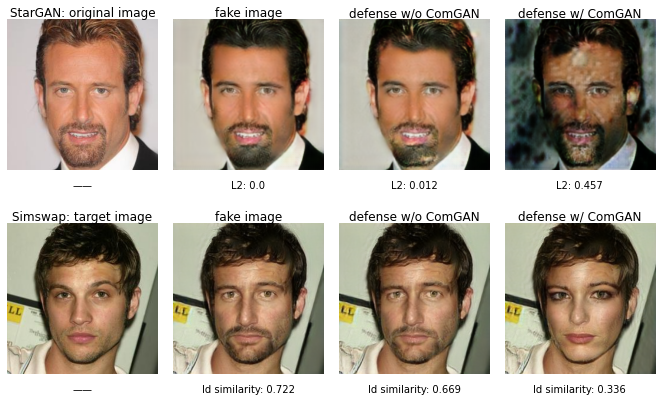

In [6]:
import matplotlib.pyplot as plt
 
name_list = ["fake image", "defense w/o ComGAN","defense w/ ComGAN"]
L2 = []
sim = []
netArc_checkpoint = opt.Arc_path
netArc_checkpoint = torch.load(netArc_checkpoint)
netArc = netArc_checkpoint['model'].module
netArc = netArc.to(device)
netArc.eval()
for i in range(len(fake_simswap)):
    L2.append(str(F.mse_loss(fake_stargan[0],fake_stargan[i]).item()))
    sim.append(str(F.cosine_similarity(netArc(F.interpolate(denorm(ori_img), size=(112,112))),
                                netArc(F.interpolate(denorm(fake_simswap[i]), size=(112,112)))).item()))


fig, axs = plt.subplots(2, 4, figsize=(10, 6))
ax = axs[0, 0]
ax.imshow(denorm(ori_img)[0].cpu().permute(1, 2, 0))
ax.axis('off')  
ax.set_title('StarGAN: original image',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 
ax.text(0.5, -0.1,'——',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 
for i, img in enumerate(fake_stargan):
    ax = axs[0, i+1]
    ax.imshow(denorm(img[0]).cpu().permute(1, 2, 0))
    ax.axis('off')  
    ax.set_title('{}'.format(name_list[i]),horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 
    ax.text(0.5, -0.1,'L2: {}'.format(L2[i][:5]),horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax = axs[1, 0]
ax.imshow(denorm(tar_img)[0].cpu().permute(1, 2, 0))
ax.axis('off')  
ax.set_title('Simswap: target image',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 
ax.text(0.5, -0.1,'——',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
for i, img in enumerate(fake_simswap):
    ax = axs[1, i+1]
    ax.imshow(denorm(img[0]).cpu().permute(1, 2, 0))
    ax.axis('off')
    ax.set_title('{}'.format(name_list[i]),horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 
    ax.text(0.5, -0.1,'Id similarity: {}'.format(sim[i][:5]),horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)

plt.show()

### Downstream tasks

As we introduced in our paper, the well-trained ComGAN can be seamlessly integrated with other adversarial attack algorithms. Here, we give a demo implementation of a pretrained generation-based adversarial attack against StarGAN that integrates ComGAN. **This will be the next phase of our work**. 

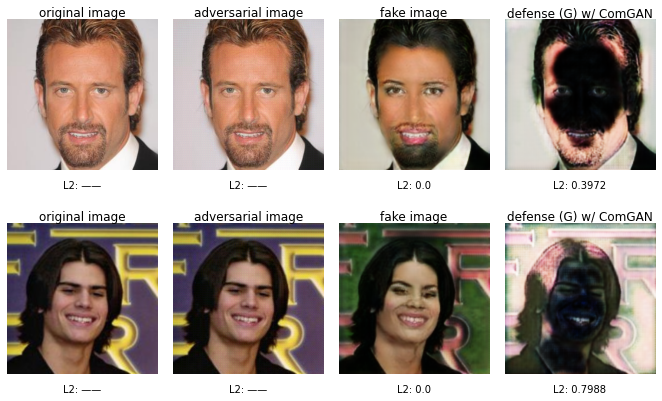

In [15]:
name_list = ["original image","adversarial image", "fake image", "defense (G) w/ ComGAN"]
ori_img_list = [Image2tensor("data/images/ori/celeba-000109.jpg"), Image2tensor("data/images/ori/lfw-000010.jpg",process=True)]

pertG = torch.load('checkpoints/PertG/df-rap_Gen_stargan.pt').to(device)
pertG.eval()

fig, axs = plt.subplots(2, 4, figsize=(10, 6))

for idx, ori_img in enumerate(ori_img_list):
    L2 = ["——","——"]

    with torch.no_grad():
        pert = pertG(ori_img)
        pert = torch.clamp(pert, -0.05, 0.05)
        x_adv = torch.clamp(ori_img+pert, -1.0, 1.0)

    c_trg = torch.tensor([[1.,0.,0.,0.,1.]]).to(device)
    save_list = [ori_img]
    save_list.append(x_adv)
    save_image(denorm(x_adv), "data/images/adv/stargan_com_Gadv"+str(idx)+".png")
    save_list.append(stargan_fake(ori_img,c_trg,starG))

    # Transmitting the x_adv images via Facebook and storing it in data/images/com_adv/facebook/
    com_adv = Image2tensor("data/images/osn_adv/facebook/stargan_com_Gadv"+str(idx)+".jpg")
    save_list.append(stargan_fake(com_adv, c_trg, starG))

    for i in range(len(save_list)-2):
        L2.append(str(F.mse_loss(save_list[2],save_list[i+2]).item()))
        
    for i, img in enumerate(save_list):
        ax = axs[idx,i]
        ax.imshow(denorm(img[0]).cpu().detach().permute(1, 2, 0))
        ax.axis('off')  
        ax.set_title(name_list[i],horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 
        ax.text(0.5, -0.1,'L2: {}'.format(L2[i][:6]),horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show()